In [1]:
import numpy as np 
import pandas as pd 
import pickle 
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [7]:
# Reading the ratings data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
len (movies)

9742

In [4]:
ratings = ratings[['userId','movieId','rating']]

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [7]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)
count_ratings.drop(['userId','movieId'],axis=1, inplace=True)

In [8]:
print("Length of Rating : ", len(ratings))
print("Length of Unique Users: ", len(ratings['userId'].unique()))

Length of Rating :  100836
Length of Unique Users:  610


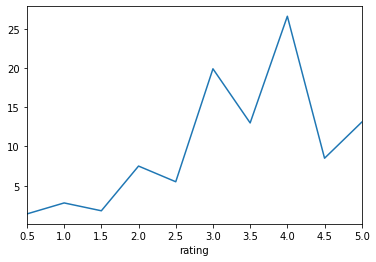

In [10]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.line()

In [11]:
"Length of Movies in the Dataset :" , len(movies)

('Length of Movies in the Dataset :', 9742)

In [12]:
genres = movies['genres']

In [13]:
genre_list = ""
for index,row in movies.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres

In [14]:
movies_with_genres = movies.copy()


In [15]:
movies_with_genres = movies.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [14]:
movies_with_genres.head()

,movieId,title,genres,War,Horror,Adventure,Drama,Fantasy,Crime,Thriller,...,Romance,Action,(no genres listed),Film-Noir,Sci-Fi,Mystery,Children,IMAX,Documentary,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
"Matrix Sparsity ", sparsity

('Matrix Sparsity ', 0.983)

In [17]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [18]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


In [19]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],50)

3.0

In [20]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
#calculate the movie score 
movie_score = avg_movie_rating.loc[avg_movie_rating['count'] > min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
5,3.071429,49,5
6,3.946078,102,6


In [21]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.drop(['movieId'],axis=1, inplace=True)
movie_score.head()

C:\Users\TomideAina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\TomideAina\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,mean,count,weighted_score
movieId,,,
1,3.920930,215,3.869578
2,3.431818,110,3.446762
3,3.259615,52,3.348131
5,3.071429,49,3.234768
6,3.946078,102,3.845051


In [26]:
# join movie details to movie ratings
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Thriller,Drama,War,Action,...,IMAX,Fantasy,Animation,Musical,Romance,Horror,Documentary,Sci-Fi,Film-Noir,Children
0,1,3.920930,215,3.869578,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
1,2,3.431818,110,3.446762,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,3,3.259615,52,3.348131,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,5,3.071429,49,3.234768,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,3.946078,102,3.845051,Heat (1995),Action|Crime|Thriller,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
82,"Shawshank Redemption, The (1994)",317,4.429022,4.348838,Crime|Drama
181,"Godfather, The (1972)",192,4.289062,4.182643,Crime|Drama
474,Fight Club (1999),218,4.272936,4.179624,Action|Crime|Drama|Thriller
66,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.153191,Action|Adventure|Sci-Fi
24,"Usual Suspects, The (1995)",204,4.237745,4.143362,Crime|Mystery|Thriller
129,Schindler's List (1993),220,4.225000,4.138187,Drama|War
76,Pulp Fiction (1994),307,4.197068,4.135153,Comedy|Crime|Drama|Thriller
227,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.126750,Action|Adventure|Sci-Fi
429,"Matrix, The (1999)",278,4.192446,4.125152,Action|Sci-Fi|Thriller
244,"Godfather: Part II, The (1974)",129,4.259690,4.116646,Crime|Drama


In [28]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [29]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
474,Fight Club (1999),218,4.272936,4.179624
66,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.153191
227,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.126750
429,"Matrix, The (1999)",278,4.192446,4.125152
229,Raiders of the Lost Ark (Indiana Jones and the...,200,4.207500,4.115420
776,"Dark Knight, The (2008)",149,4.238255,4.114786
228,"Princess Bride, The (1987)",142,4.232394,4.104923
237,Apocalypse Now (1979),107,4.219626,4.062385
374,Saving Private Ryan (1998),188,4.146277,4.057554
238,Star Wars: Episode VI - Return of the Jedi (1983),196,4.137755,4.053304


In [30]:
U, M = matrix_factorization_utilities.low_rank_matrix_factorization(ratings_df.as_matrix(),
                                                                    num_features=5,
                                                                    regularization_amount=1.0)

C:\Users\TomideAina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Optimization terminated successfully.
         Current function value: 1159.644172
         Iterations: 72
         Function evaluations: 143
         Gradient evaluations: 143


In [31]:
# Creating a data frame that has user ratings accross all movies in form of matrix used in matrix factorisation
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max).fillna(0)
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    0.0    4.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   
2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5          4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...                                                                 \
movieId  ... 193565 193567 193571 193573 193579 193581 193583 193585 193587   
userId   ...                                                                  
1        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5        ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 193609  
userId          
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  

[5 rows x 9724 columns]

In [32]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movies, on = 'movieId')

In [33]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [34]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title'] == movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [34]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

,userId,perc_who_watched
title,,
Gone Girl (2014),37,100.0
Fight Club (1999),34,91.9
Inception (2010),30,81.1
"Shawshank Redemption, The (1994)",30,81.1
"Matrix, The (1999)",30,81.1
Forrest Gump (1994),28,75.7
Django Unchained (2012),27,73.0
"Silence of the Lambs, The (1991)",26,70.3
Interstellar (2014),26,70.3


In [35]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

In [36]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


In [37]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
movie_plus_10_ratings.drop(['movieId'], axis=1, inplace=True)

C:\Users\TomideAina\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [38]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings, on="movieId")
len(filtered_ratings)

81116

In [39]:
filtered_ratings.head()

,movieId,mean,count,userId,rating
0,1,3.92093,215,1,4.0
1,1,3.92093,215,5,4.0
2,1,3.92093,215,7,4.5
3,1,3.92093,215,15,2.5
4,1,3.92093,215,17,4.5


In [42]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_set, test_set = train_test_split(movie_wide,test_size=0.33, random_state=42)

In [48]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(train_set)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [45]:
#function to get topRecommendation using the Nearest Neighbour Algorithm 
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movies.loc[movies['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movies.loc[movies['movieId']== movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [49]:
test_set.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0
6709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,3.5
5673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.5,0.0,0.0


In [50]:
print_similar_movies(765)

Recommendations for 609    Jack (1996)
Name: title, dtype: object:

1: 332    Richie Rich (1994)
Name: title, dtype: object, with distance of 0.576112085337299:
2: 365    Black Beauty (1994)
Name: title, dtype: object, with distance of 0.6539165708083601:
3: 2174    Three Kings (1999)
Name: title, dtype: object, with distance of 0.664642136651442:
4: 404    Hot Shots! Part Deux (1993)
Name: title, dtype: object, with distance of 0.6694853949318744:
5: 1934    King and I, The (1956)
Name: title, dtype: object, with distance of 0.6826242168512454:
6: 958    Stand by Me (1986)
Name: title, dtype: object, with distance of 0.6828206660230656:
7: 4026    Saturday Night Fever (1977)
Name: title, dtype: object, with distance of 0.6837759007534064:
8: 921    Blues Brothers, The (1980)
Name: title, dtype: object, with distance of 0.6869177020382928:
9: 650    Emma (1996)
Name: title, dtype: object, with distance of 0.6934101861652117:
10: 1962    Entrapment (1999)
Name: title, dtype: object, wit

In [51]:
def pearson_r(x1, y1):
    """Take two pd series objects and returns a pearson correlation"""
    x1_c = x1 - x1.mean()
    y2_c = y1 - y1.mean()
    return np.sum(x1_c * y2_c)/ np.sqrt(np.sum(x1_c ** 2) * np.sum(y2_c ** 2))

In [53]:
#checking the similarity between the two movies
pearson_r(movie_wide[8], movie_wide[67])

0.07993769577905079

In [55]:
temp_ratings = ratings.copy()

In [56]:
def replace_name(x):
    return movies[movies['movieId'] == x ].title.values[0]
temp_ratings.movieId = temp_ratings.movieId.map(replace_name)


In [94]:
ratings_matrix = temp_ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating' )

movieId,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [57]:
#function to get topRecommendation using the Pearson Correlation Algorithm
def getTopRecs(movie_name, M, num):
    import numpy as np
    reviews = []
    for title in M.columns:
        if title == movie_name:
            continue
        cor = pearson_r(M[movie_name], M[title])
        if np.isnan(cor):
            continue
        else:
            reviews.append((title,cor))
    reviews.sort(key=lambda tup: tup[1], reverse=True)
    return reviews[:num]

In [58]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
movie_content_df = movie_content_df.values
movie_content_df

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [59]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [60]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title']) 

In [61]:
#Gets the top 10 similar movies based on the content
def get_similar_movies_based_on_content(movie_index) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [62]:
indicies["Final Destination 2 (2003)"]

4197

In [185]:
get_similar_movies_based_on_content(4197)

[(21, 2.0), (62, 2.0), (81, 2.0), (154, 2.0), (270, 2.0), (286, 2.0), (324, 2.0), (339, 2.0), (352, 2.0), (370, 2.0), (510, 2.0)]
[21, 62, 81, 154, 270, 286, 324, 339, 352, 370, 510]


,title,genres
21,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller
62,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
81,Mary Reilly (1996),Drama|Horror|Thriller
154,Mute Witness (1994),Comedy|Horror|Thriller
270,Relative Fear (1994),Horror|Thriller
286,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller
324,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller
339,Wolf (1994),Drama|Horror|Romance|Thriller
352,In the Mouth of Madness (1995),Horror|Thriller
370,Body Snatchers (1993),Horror|Sci-Fi|Thriller


In [63]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()


,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [64]:
#get ordered list of userIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [70]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame

df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,1,4.0,0,0
1,1,3,4.0,2,0
2,1,6,4.0,5,0
3,1,47,5.0,43,0
4,1,50,5.0,46,0


In [71]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

80668
20168


In [72]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]

n_items

9724

In [73]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
10303,137,260,4.0,224,136
95779,503,1089,4.5,827,502
86741,497,96829,5.0,7971,496
34013,385,1234,4.0,933,384
52356,562,968,4.5,741,561


In [74]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
#     #set the value in the column and row to 
#     #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(610, 9724)

In [166]:
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test.itertuples():
#     #set the value in the column and row to 
#     #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    test_data_matrix[line[5], line[4]] = line[3]
test_data_matrix.shape

(610, 9724)

In [77]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df_train['rating'].max()

5.0

In [235]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [236]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 3.1446741519398733
Matrix Factorisation with 2 latent features has a RMSE of 3.0639087472344557
Matrix Factorisation with 5 latent features has a RMSE of 2.973843968000034
Matrix Factorisation with 20 latent features has a RMSE of 3.0238492897989118
Matrix Factorisation with 40 latent features has a RMSE of 3.1344347667863954
Matrix Factorisation with 60 latent features has a RMSE of 3.2346146020599598
Matrix Factorisation with 100 latent features has a RMSE of 3.3827961160299496
Matrix Factorisation with 200 latent features has a RMSE of 3.551117601372498


In [81]:
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.342706,-0.165565,3.773726,0.021863,0.267074,3.908377,0.386955,-0.045170,0.237145,-0.252649,...,0.0,0.049948,0.0,0.066597,0.058272,0.0,0.058272,0.058272,0.058272,-0.038692
1,-0.232573,0.141898,-0.054948,0.005404,-0.033094,-0.303271,0.048481,0.018961,-0.101250,0.258288,...,0.0,0.045413,0.0,0.060551,0.052982,0.0,0.052982,0.052982,0.052982,0.052683
2,0.074398,0.097285,0.098738,0.034396,0.033523,0.266713,0.003726,-0.020403,0.002202,-0.046579,...,0.0,0.003749,0.0,0.004999,0.004374,0.0,0.004374,0.004374,0.004374,-0.011793
3,-0.264841,-0.451363,-0.104759,0.086933,-0.141090,-0.424155,0.355526,-0.044864,-0.237548,0.691019,...,0.0,0.043928,0.0,0.058570,0.051249,0.0,0.051249,0.051249,0.051249,-0.015138
4,2.382908,0.593480,-0.298776,0.132741,0.155309,0.140003,0.191014,0.089674,-0.163355,0.465410,...,0.0,-0.002898,0.0,-0.003863,-0.003381,0.0,-0.003381,-0.003381,-0.003381,0.044347


In [82]:
df_names = pd.merge(ratings,movies,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [222]:
#choose a user ID
user_id = 45
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
# users_movies = users_movies.loc[users_movies['rating'] >=4.0]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

User ID : 45 has already rated 399 movies


,userId,movieId,rating,title,genres
15,45,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
276,45,6,4.0,Heat (1995),Action|Crime|Thriller
591,45,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
780,45,70,4.0,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
870,45,110,5.0,Braveheart (1995),Action|Drama|War
1217,45,216,5.0,Billy Madison (1995),Comedy
1269,45,223,5.0,Clerks (1994),Comedy
1377,45,231,5.0,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
1585,45,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1845,45,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [223]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
predictions = pd.merge(sorted_user_predictions,movies, on = 'movieId')

Top 10 predictions for User 45


In [120]:
#Evaluation Metrics for matrix factorization model 
#computing recall of the recommender system 

In [224]:
df = users_movies.merge(predictions, how = 'inner' ,indicator=False)
tp = len(df) # Length of Movies that the User likes that was recommended 
tp_fn = len(users_movies) #lenght of movies in total that a user likes 

print("Recall for user: " , user_id, '=',tp/tp_fn)


Recall for user:  45 = 0.9649122807017544


In [225]:
df = predictions.merge(users_movies, how = 'inner' ,indicator=False)
tp = len(df) # Length of Movies that the User likes that was recommended 
tp_fp = len(predictions) #lenght of predicted items

print("Precision for user: " , user_id, '=', tp/tp_fp)

Precision for user:  45 = 0.07128309572301425


In [218]:
predictions.head()

,ratings,movieId,title,genres
0,5.648698,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery
1,5.401831,3563,"Crow: Salvation, The (2000)",Action|Horror
2,5.382300,1186,"Sex, Lies, and Videotape (1989)",Drama
3,5.359765,92,Mary Reilly (1996),Drama|Horror|Thriller
4,5.329571,2370,"Emerald Forest, The (1985)",Action|Adventure|Drama


In [226]:
# predictions[:10]
dataframe = pd.merge(predictions,ratings,indicator=False,on='movieId')
# dataframe['difference'] = (dataframe['ratings'] - dataframe['rating']) ** 2

In [231]:
import math 
rmse = math.sqrt(mean_squared_error(dataframe['ratings'],dataframe['rating']))

In [232]:
print('RMSE FOR USER ', user_id, '= ',rmse)

RMSE FOR USER  45 =  3.5548322610101972
